# Learning Holographic Dual Metric by Receiving Experimental Data
## **<font color = orange>_Implemented by Pytorch_</font>**
### **<font color = red>Reference: Phys. Rev. D 98,106014 (2018)</font>**

## Package

In [1]:
import numpy as np
import random as random
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import animation
from celluloid import Camera
import torch
from torch import nn
from torchviz import make_dot, make_dot_from_trace
from torch import optim
from torchdiffeq import odeint_adjoint as odeint
from decimal import *
import numpy as np
from mpmath import *
from sympy import *
import scipy.integrate as integrate
import scipy.special as sc
from scipy.misc import derivative
from pynverse import inversefunc
import pandas as pd
from pandas import Series,DataFrame
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Setting paramters

In [2]:
n=2 #n+2 dim
scale=1
d=n+2 #dimension of spa
m2=-1  #m^2
lam=1 #lambda: coefficient for phi-4 potential
q=0 #black hole charge
uv_cutoff=1/scale #UV cutoff
ini_eta=uv_cutoff #initial eta
ir_cutoff=0.1/scale #IR cutoff
layer=20 #N layer
num_training_data=1000 #number of training data
delta_eta=-(uv_cutoff-ir_cutoff)/(layer-1)  #interval between layers

## Final Layer

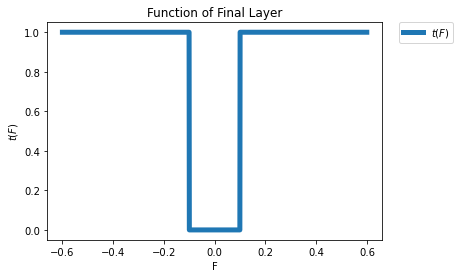

In [3]:
def t(F):
    signr= np.heaviside(F-ir_cutoff,0)
    signl= np.heaviside(-F-ir_cutoff,0)
    return  signr+signl
Fp= np.arange(-0.6, 0.6, 0.001) #step
plt.plot(Fp,t(Fp), lw=5, label='$t(F)$')
plt.title('Function of Final Layer')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('F')
plt.ylabel('$t(F)$')
#plt.tight_layout()
#plt.savefig("Tanh.png")
plt.show()

## Setup

We consider scalar field $\phi$ only dependent on holographic direction $z$
$$ \tag{1}
\mathcal{L}_{\text{matter}}=\sqrt{-\det (g)} \left(-\frac{1}{2} m^2 \phi ^2-V(\phi )-\frac{1}{2} \left(\frac{\partial \phi }{\partial z}\right)^2\right)
$$

in asymptotic AdS black hole background
$$ \tag{2}
ds^2=\frac{1}{z^2}\left(-h(z)dt^2+\frac{dz^2}{h(z)}+\sum _{i=1}^n dx_i^2\right)
$$
where emblackening function have following properties
$$ \tag{3}
h(0)=1~~~\& ~~~ h(1)=0~~~\left(\text{For simplicity, we set } z_h=1\right)
$$

Specially, 
$$\tag{4}
h(z)=1-z^3-Q^2 z^3+Q^2 z^4
$$

in RN case. Note that, in extremal case, $Q=\sqrt{3}$. 

## Reproduced Metric and EoM

The EoM for $\phi(z)$ is
$$\tag{5}
z^2 h(z) \phi ''(z)+\left(z^2 h'(z)-2 z h(z)\right) \phi '(z)-m^2 \phi -\frac{\delta V(\phi )}{\delta \phi }=0
$$
Now we're wanna let $g_{11}=1$. Consider the following coordinate transformation
$$\tag{6}
d\eta=-\frac{dz}{z \sqrt{h(z)}}~,~~~\eta =\int _z^{z_h=1}\frac{dz}{z \sqrt{h(z)}}
$$
Then the EoM become
$$\tag{7}
\frac{\partial \Pi }{\partial \eta }+  H_R(\eta )\Pi-m^2 \phi-\frac{\delta V(\phi )}{\delta \phi }=0~,~~~H_R(\eta )\equiv\frac{6 h(z(\eta ))-y h'(z(\eta ))}{2 \sqrt{h(z(\eta ))}}
$$
where $\Pi :=\frac{\partial \phi }{\partial \eta }$. Specially,  for Schwarzschild case, 
$$\tag{8}
z=\text{sech}^{\frac{2}{3}}\left(\frac{3 \eta }{2}\right)~,~~~H_R(\eta )=3 \coth (3 \eta )
$$

In [4]:
def h(y):
    return 1-y**3-(q**2)*y**3+(q**2)*y**4

def eta_coord(y):
    r=[]
    for i in range (0,len(y)):
        r=np.append(r,integrate.quad(lambda z: 1/(z*(h(z)**(1/2))), y[i],1)[0])
    return r

def y_coord(eta):
    r=[]
    accep_error=10**(-3)
    for i in range (0,len(eta)):
        erroreta=100
        y_lower=0
        y_upper=1
        while abs(erroreta) > accep_error:
            yy=(y_lower+y_upper)/2
            test_eta=eta_coord(np.array([yy]))
            if test_eta > eta[i] :
                 y_lower=yy
            else: 
                 y_upper=yy
            erroreta=eta[i]-test_eta
        r=np.append(r,yy)  
    return r

def H_r(eta):
    eta=eta/scale
    return (6*h(y_coord(eta))-y_coord(eta)*derivative(h,y_coord(eta), dx=1e-6))/(2*(h(y_coord(eta))**(1/2)))

def v(phi):
    return (lam*phi**4)/4 #delta_v(phi)-> derivative(v,phi)

def ff(eta,phi,pi):
    return (derivative(v,phi, dx=1e-6)-H_r(eta*scale)*pi*scale+phi*m2)*scale**2


eta_base=[]
for i in range(0,int(layer)):
    eta_base.append(ir_cutoff+i*abs(delta_eta))
tanh = nn.Tanh()
print(len(eta_base),eta_base[layer-1],layer)

20 1.0 20


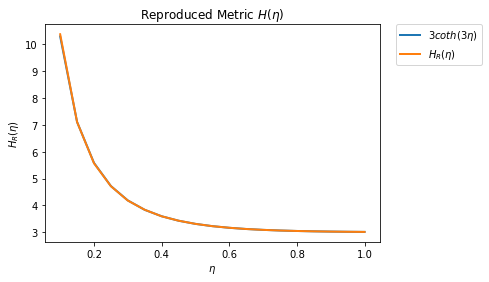

In [5]:
xx=np.arange(0.1, 1.05/scale, 0.05)
plt.plot(xx,3*np.cosh(3*xx/scale)/np.sinh(3*xx/scale), lw=2, label='$3 coth(3\eta)$')
plt.plot(xx,H_r(xx), lw=2, label='$H_R(\eta)$')
plt.title('Reproduced Metric $H(\eta)$')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('$\eta$')
plt.ylabel('$H_R(\eta)$')
#plt.tight_layout()
#plt.savefig("Hr_rnq09_n3.png")
plt.show()

## Activation Function
### **<font color = orange>_Runge-Kutta Fourth-Order_</font>**

From EoM, let's say
$$\tag{9}
\tilde{f}(\eta ,\phi ,\Pi )\equiv \frac{\partial \Pi }{\partial \eta }=-H_R\Pi+m^2 \phi+\frac{\delta V(\phi )}{\delta \phi }
$$
The activation function at each layer is
$$
\phi (\Delta \eta +\eta )=\phi (\eta )+\Delta \eta  \left(\Pi (\eta )+\frac{1}{3} \left(k_1+k_2+k_3\right)\right)\\
\Pi (\Delta \eta +\eta )=\Pi (\eta )+\frac{1}{3} \left(k_1+2 k_2+2 k_3+k_4\right)\tag{10}
$$
where $k_1, k_2, k_3, k_4$ are defined by
$$
k_1\equiv\frac{\Delta \eta }{2}  \tilde{f}(\eta ,\phi ,\Pi )\\
k_2\equiv\frac{\Delta \eta}{2}   \tilde{f}\left(\eta+\frac{\Delta \eta }{2} ,\phi+k ,\Pi+k_1 \right),~~~k\equiv\frac{\Delta \eta }{2}  \left(\Pi+\frac{k_1}{2} \right)\\
k_3\equiv\frac{\Delta \eta}{2}   \tilde{f}\left(\eta+\frac{\Delta \eta }{2} ,\phi+k ,\Pi+k_2 \right)\\
k_4\equiv\frac{\Delta \eta}{2}   \tilde{f}\left(\eta+\Delta \eta ,\phi+\ell  ,\Pi+2 k_3 \right),~~~\ell \equiv\Delta \eta  \left(k_3+\Pi \right)
$$

In [6]:
phi_list_pos_exp=[]
pi_list_pos_exp=[]
phi_list_neg_exp=[]
pi_list_neg_exp=[]
phi_exp_data=[]
pi_exp_data=[]
train_data_y=[]
np.random.seed(1)
while len(phi_list_pos_exp)<num_training_data or len(phi_list_neg_exp)<num_training_data :
        eta=uv_cutoff
        phi_ini=np.random.uniform(low=0, high=1.7, size=(num_training_data*50)) #random.uniform(0,1)
        pi_ini=np.random.uniform(low=-0.2, high=0.7, size=(num_training_data*50))*scale#random.uniform(-1.7,0.01)
        phi=phi_ini
        pi=pi_ini
        for i in range(0,int(layer-1)):
            k1=delta_eta*ff(np.array([eta]),phi,pi)/2
            k=delta_eta*(k1/2+pi)/2
            k2=delta_eta*ff(np.array([eta+delta_eta/2]),phi+k,pi+k1)/2
            k3=delta_eta*ff(np.array([eta+delta_eta/2]),phi+k,pi+k2)/2
            ell=delta_eta*(pi+k3)
            k4=delta_eta*ff(np.array([eta+delta_eta]),phi+k,pi+2*k3)/2
            
            phi_new=phi+delta_eta*(pi+(k1+k2+k3)/3)
            pi_new=pi+(k1+2*k2+2*k3+k4)/3
            eta+=delta_eta
            phi=phi_new
            pi=pi_new
        for j in range(0,len(phi)):
            final_layer=t(pi[j])
            if final_layer>0.5: #2*pi/eta-m2*phi-delta_v(phi)
                if len(phi_list_neg_exp)<num_training_data:
                    phi_list_neg_exp.append(phi_ini[j])
                    pi_list_neg_exp.append(pi_ini[j])
                    phi_exp_data.append(phi_ini[j])
                    pi_exp_data.append(pi_ini[j])
                    train_data_y.append(final_layer) #false t(pi)=1
            else: 
                if len(phi_list_pos_exp)<num_training_data:
                    phi_list_pos_exp.append(phi_ini[j])
                    pi_list_pos_exp.append(pi_ini[j])
                    phi_exp_data.append(phi_ini[j])
                    pi_exp_data.append(pi_ini[j])
                    train_data_y.append(final_layer) #true t(pi)=0
                    #print(len(train_data_y))

## Generating Data by Real Metric

Set $\epsilon =0.1$

True: $\Pi \leq \epsilon$  $\qquad$  False: $\Pi >\epsilon$

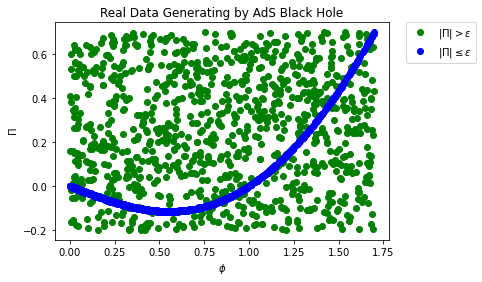

In [7]:
plt.plot(phi_list_neg_exp,pi_list_neg_exp,'o',color='g', label='$|\Pi|>\epsilon$')
plt.plot(phi_list_pos_exp,pi_list_pos_exp,'o',color='b', label='$|\Pi|\leq\epsilon$')
plt.title('Real Data Generating by AdS Black Hole')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('$\phi$')
plt.ylabel('$\Pi$')
#plt.tight_layout()
#plt.savefig("data_rnq09_3n.png")
plt.show()

## Flowchart

<img src=pic/chart.PNG width=300></img>

## Assumptions of Reproduced Metric $H_R(\eta )$

$$\tag{A1}
H_R(\eta )\in \mathcal{C}_{\infty }~~~\forall \eta \geq 0
$$
$$\tag{A2}
H_R(\eta )\to \frac{1}{\eta }~~~\text{as}~~~\eta\to 0
$$
$$\tag{A3}
H_R(\eta )\to (n+1)~~~\text{as}~~~\eta\to \infty~~~(\text{in } (n+2)\text{-dimensional spacetime})
$$
Thus we are able to say
$$
H_R(\eta )=H^{\text{ir}}{}_R(\eta )\text{:=}\frac{c_{-1}}{\eta }+c_0+c_1 \eta +c_2 \eta ^2+\text{...}=\overset{\rightharpoonup }{c}.\overset{\rightharpoonup }{\eta }_{\text{ir}}~~~\text{as}~~\eta <\eta ^*\\
H_R(\eta )=H^{\text{uv}}{}_R(\eta )\text{:=}=d_0+d_1 \eta +d_2 \eta ^2+\text{...}=\overset{\rightharpoonup }{d}.\overset{\rightharpoonup }{\eta }_{\text{uv}}~~~\text{as}~~\eta >\eta ^*
$$
where $\eta ^*$  is matching point. ($\eta ^*$=0.5 in our code) Due to (A2),
$$
c_{-1}=1 ~~~\text{and}~~~~ c_0=0
$$
From (A3), we can fix two of coefficient $\overset{\rightharpoonup }{d}=(d_0, d_1, d_2, ...)$. Moreover, because of (A1), we have matching condition
$$
H^{\text{ir}}{}_R\left(\eta ^*\right)=H^{\text{uv}}{}_R\left(\eta ^*\right),~~~\frac{\partial H^{\text{ir}}{}_R\left(\eta ^*\right)}{\partial \eta }=\frac{\partial H^{\text{uv}}{}_R\left(\eta ^*\right)}{\partial \eta },\text{...}\text{...}
$$

In [8]:
ReLU= nn.ReLU()
from torch.autograd import grad
def factorial(n):
    if n == 0:
        return 1
    else:
        return n*factorial(n-1)

def D(f,x,n):
    x=torch.tensor([float(x)], requires_grad=True)
    func=f(x)
    for i in range(n):
        grads=grad(func, x, create_graph=True)[0]
        func=grads
    return grads
def DP(x,power,n):
    if n>power and power>=0:
        return torch.tensor([0.])
    x=torch.tensor([float(x)], requires_grad=True)
    if n==0:
        return P(power,x)
    else:
        func=P(power,x)
        for i in range(n):
            grads=grad(func, x, create_graph=True)[0]
            func=grads
        return grads
    
def D_fitting_results_exp(fitting_results_exp,h_fitting_vec_tensor_ir,x,n):
    x=torch.tensor([float(x)], requires_grad=True)
    func=fitting_results_exp(h_fitting_vec_tensor_ir,x)
    for i in range(n):
        grads=grad(func, x, create_graph=True)[0]
        func=grads
    return grads

In [17]:
def fitting_results_exp(h_fitting_vec_tensor_ir,x):
    x=x/scale
    def h_bhk_uv(eta):
        def h_bhk_uv_sub(eta):
            summ=P(0,eta)*h_fitting_vec_tensor_ir[0]
            for i in range(1,int(n_ir)):
                summ+=P(i,eta)*h_fitting_vec_tensor_ir[i]
            return summ
        return h_bhk_uv_sub(eta)
        
    def h_bhk_ir(eta):
        #A_matrix
        A_mat=torch.zeros(n_ir, n_ir, dtype=torch.float64)
        for i in range(0,n_ir):
            for j in range(0,n_ir):
                A_mat[i][j]=A_mat[i][j]+DP(ma_pt,j+1,i)
        A_inverse=torch.inverse(A_mat)
            
        #b_vec
        b_vec=torch.zeros(n_ir, 1, dtype=torch.float64)
        b_vec[0]=b_vec[0]+h_bhk_uv(ma_pt)-1/ma_pt
        for i in range(1,n_ir):
            b_vec[i]=b_vec[i]+D(h_bhk_uv,ma_pt,i)-DP(ma_pt,-1,i)

        #A_matrix**(-1) dot b_vec
        x_vec=torch.mm(A_inverse,b_vec)

        r=1/eta
        for i in range(0,n_ir):
            r+=x_vec[i]*P(i+1,eta)
        return r
    
    if eta<ma_pt:
        return h_bhk_ir(x)
    else:
        return h_bhk_uv(x)

In [18]:
n_ir=2
#n_uv=8
ma_pt=ini_eta/2#(ini_eta-ir_cutoff)/2
#np.random.seed(7)
avr=random.uniform(-1,1)
h_fitting_vec_ir=[]
for i in range(0,int(n_ir)):
    h_fitting_vec_ir.append([np.random.randn()+avr])#np.random.randn()
h_fitting_vec_tensor_ir=torch.tensor(h_fitting_vec_ir, requires_grad=True)
print(h_fitting_vec_tensor_ir,len(h_fitting_vec_tensor_ir))
def P(n,x):
    return  x**n

class PyTorchLinearRegression_fitting(nn.Module):
    def __init__(self):
        super().__init__()
        self.training_data_ir = nn.Parameter(h_fitting_vec_tensor_ir)
        
    def forward(self,eta,phi,pi):
        
        def ff_tensor(eta,phi,pi):
            return (derivative(v,phi, dx=1e-6)-fitting_results_exp(self.training_data_ir,eta*scale)*pi*scale+phi*m2)*scale**2
        
        def t_tensor(F):
            return 1-torch.exp(-(torch.abs(F)**2.5)/0.03) #ReLU(F-ir_cutoff)+ReLU(-F-ir_cutoff) #(tanh(wi*(F-0.1))-tanh(wi*(F+0.1))+2)/2 #(F**2)*wi
        
        def ir_reg(order,coe,training_data_ir):
            r=0
            for j in range(0,int(order+1)):
                the=factorial(j)*((-1)**j)*(1/(ir_cutoff)**(1+j))
                if j==0:
                    exp=training_data_ir[0]
                else:
                    exp=D_fitting_results_exp(fitting_results_exp,training_data_ir,ir_cutoff,j)
                r+=coe*ReLU(abs(the-exp)-1/(ir_cutoff)**(j))**2 #ReLU(abs(the-exp)-1/(ir_cutoff)**(j))**2
            return r

        for i in range(0,layer-1):
            k1=delta_eta*ff_tensor(eta,phi,pi)/2
            k=delta_eta*(k1/2+pi)/2
            k2=delta_eta*ff_tensor(eta+delta_eta/2,phi+k,pi+k1)/2
            k3=delta_eta*ff_tensor(eta+delta_eta/2,phi+k,pi+k2)/2
            ell=delta_eta*(pi+k3)
            k4=delta_eta*ff_tensor(eta+delta_eta,phi+k,pi+2*k3)/2

            phi_new=phi+delta_eta*(pi+(k1+k2+k3)/3)
            pi_new=pi+(k1+2*k2+2*k3+k4)/3
            eta+=delta_eta
            phi=phi_new
            pi=pi_new
        #2*pi/eta-m2*phi-delta_v(phi)
        order=0
        coe=0.1
        return (t_tensor(pi),torch.sum(self.training_data_ir**2),ir_reg(order,coe,self.training_data_ir))
    
model_fitting = PyTorchLinearRegression_fitting()#.to(device)
print(model_fitting.state_dict())

tensor([[-2.3964],
        [-0.3960]], requires_grad=True) 2
OrderedDict([('training_data_ir', tensor([[-2.3964],
        [-0.3960]]))])


## Optimizer: Adam

$$
\hat{m}_{i+1}\leftarrow \frac{\left(1-\beta _1\right) \nabla _{\overset{\rightharpoonup }{d}}L_i+\beta _1 \left(1-\beta _1^{i+1}\right) \hat{m}_i}{1-\beta _1^{i+1}}\\
\hat{v}_{i+1}\leftarrow \frac{\left(1-\beta _2\right) \left(\nabla _{\overset{\rightharpoonup }{d}}L_i\right){}^2+\beta _2 \left(1-\beta _2^{i+1}\right) \hat{v}_i}{1-\beta _2^{i+1}}\\
\overset{\rightharpoonup }{d}_{i+1}\leftarrow \overset{\rightharpoonup }{d}_i-\frac{\hat{m}_i \eta _{\ell }}{\delta +\sqrt{\hat{v}_i}}
$$

In [19]:
lr_xp_fitting=0.03 #0.03
lair=0.1
irc=0
cm=10
uvd=0.1
optimizer_exp_fitting=optim.Adam(model_fitting.parameters(), lr=lr_xp_fitting) #RMSprop #Adam
MSELoss = nn.MSELoss()
def build_train_step_exp_fitting(model, loss_fn, optimizer):
    
    def train_step_exp_fitting(eta,phi,pi, y):   
        
        #Training Model
        model_fitting.train()
        
        # Prediction
        yhat = model_fitting(eta,phi,pi)
        
        #Computing Loss Function
        
        loss = loss_fn(y, yhat[0])+lair*yhat[1]+yhat[2]
        
        #Computing Gradient
        loss.backward()
        
        #Optimization
        optimizer.step() 
        optimizer.zero_grad()
        return loss.item() 
    return train_step_exp_fitting
train_step_exp_fitting = build_train_step_exp_fitting(model_fitting, MSELoss, optimizer_exp_fitting)
print(model_fitting.state_dict())

OrderedDict([('training_data_ir', tensor([[-2.3964],
        [-0.3960]]))])


In [20]:
from torch.utils.data import Dataset
class SLRDataset(Dataset):
    def __init__(self, phi_exp_data_tensor, pi_exp_data_tensor, train_data_y_tensor):
        self.phi = phi_exp_data_tensor
        self.pi = pi_exp_data_tensor
        self.train = train_data_y_tensor
        
    def __getitem__(self, index):
        return (self.phi[index],self.pi[index], self.train[index])
    def __len__(self):
        return len(self.phi)
#
phi_exp_data_tensor = torch.from_numpy(np.array(phi_exp_data))
pi_exp_data_tensor = torch.from_numpy(np.array(pi_exp_data))
train_data_y_tensor = torch.from_numpy(np.array(train_data_y))
training_data = SLRDataset(phi_exp_data_tensor,pi_exp_data_tensor, train_data_y_tensor)

from torch.utils.data import DataLoader
train_loader = DataLoader(dataset=training_data, batch_size=50, shuffle=True)

In [21]:
epochs=10
loss_epoch=[]
for epoch in range(epochs):
    losses_xp_fitting = []
    for phi_batch,pi_batch, train_batch in train_loader:
        loss = train_step_exp_fitting(ini_eta, phi_batch,pi_batch,train_batch)
        losses_xp_fitting.append(loss)
    loss_epoch.append(np.sum(losses_xp_fitting)/len(losses_xp_fitting))
    print('loss_epoch=',np.sum(losses_xp_fitting)/len(losses_xp_fitting))
print(model_fitting.state_dict())

loss_epoch= 12.358866596221924
loss_epoch= 9.669654583930969
loss_epoch= 7.773796164989472
loss_epoch= 6.478020656108856
loss_epoch= 5.501032030582428
loss_epoch= 4.766412723064422
loss_epoch= 4.42119995355606
loss_epoch= 4.286863183975219
loss_epoch= 4.241568195819855
loss_epoch= 4.228258776664734
OrderedDict([('training_data_ir', tensor([[ 3.8222],
        [-0.8429]]))])


In [22]:
did_p=100*uv_cutoff
interval=(ini_eta-ir_cutoff)/did_p
eta=ir_cutoff
fitting_results_exp_h=[]
fitting_results_exp_eta=[]
for i in range(0,int(did_p+1)):
    fitting_results_exp_eta.append(eta)
    fitting_results_exp_h.append(fitting_results_exp(h_fitting_vec_tensor_ir,eta))
    eta+=interval

interval=(ini_eta-ir_cutoff)/did_p
eta=ir_cutoff
before_h=[]
before_eta=[]
for i in range(0,int(did_p+1)):
    before_eta.append(eta)
    before_h.append(fitting_results_exp(torch.tensor(h_fitting_vec_ir),eta))
    eta+=interval

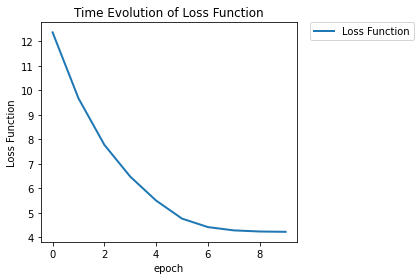

In [23]:
plt.plot(loss_epoch, lw=2, label='Loss Function')
plt.title('Time Evolution of Loss Function')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('epoch')
plt.ylabel('Loss Function')
plt.tight_layout()
plt.savefig("loss_rnq09_3n_1.png")
plt.show()

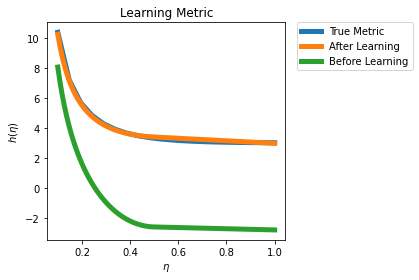

In [24]:
plt.plot(np.array(eta_base),H_r(np.array(eta_base)), lw=5, label='True Metric')
plt.plot(fitting_results_exp_eta,fitting_results_exp_h, lw=5, label='After Learning')
plt.plot(before_eta,before_h, lw=5, label='Before Learning')
plt.title('Learning Metric')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('$\eta$')
plt.ylabel('$h(\eta)$')
plt.tight_layout()
plt.savefig("learning_rnq09_3n_1.png")
plt.show()